In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import StandardScaler, LabelEncoder , OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score,roc_curve, roc_auc_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from imblearn.over_sampling import SMOTE


In [96]:
sales=pd.read_excel(r"C:\Users\moham\Documents\final project\Fact_Sales.xlsx")
customers=pd.read_excel(r'c:\Users\moham\Documents\final project\Dim_Customer.xlsx')
category=pd.read_excel(r"C:\Users\moham\Documents\final project\Dim_Category.xlsx")
country=pd.read_excel(r"C:\Users\moham\Documents\final project\Dim_Country1.xlsx")
date=pd.read_excel(r"C:\Users\moham\Documents\final project\Dim_Date.xlsx")
location=pd.read_excel(r"C:\Users\moham\Documents\final project\Dim_Location.xlsx")
product=pd.read_excel(r"C:\Users\moham\Documents\final project\Dim_Product.xlsx")
subcategory=pd.read_excel(r"C:\Users\moham\Documents\final project\Dim_SubCategory.xlsx")

In [97]:
data = sales.merge(customers, on="CustomerID", how="left") \
               .merge(product, on="ProductID", how="left") \
               .merge(subcategory, on="SubCategoryID", how="left") \
               .merge(category, on="CategoryID", how="left") \
               .merge(location, on="LocationID", how="left") \
               .merge(country, on="CountryID", how="left")

data.head()
data.to_csv("merged_data_3.csv", index=False, encoding="utf-8")

In [98]:
num_cols = ["Quantity","UnitPrice","TotalAmount","Age","Price","Cost"]
for col in num_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    data = data[(data[col] >= lower) & (data[col] <= upper)]


In [99]:
data['Revenue'] = data['Quantity'] * data['UnitPrice']
data["Profit"] = data["Price"] - data["Cost"]

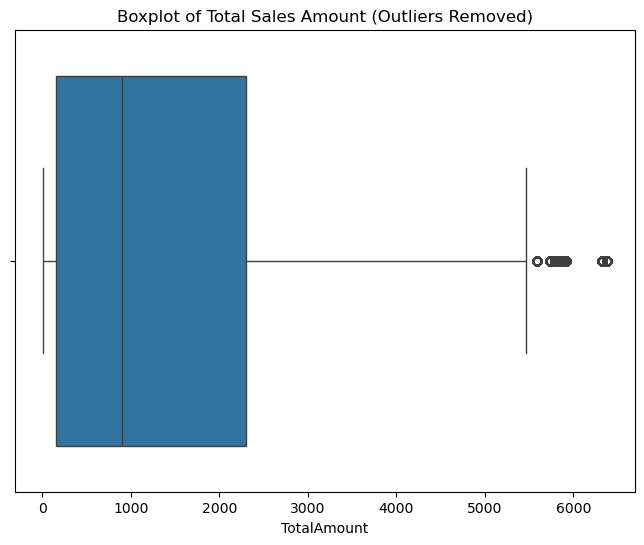

In [100]:
plt.figure(figsize=(8,6))
sns.boxplot(x=data["TotalAmount"])
plt.title("Boxplot of Total Sales Amount (Outliers Removed)")
plt.show()


# Encoding and proccessing 

In [101]:
keep_cols = [
    "Quantity","UnitPrice","TotalAmount","Age","Price","Cost",
    "Gender","CategoryName","Region","Country","State","City",
    "ProductID","InvoiceDate","CustomerID","Revenue"
]
data_features = data[keep_cols]

data_features.head()


,Quantity,UnitPrice,TotalAmount,Age,Price,Cost,Gender,CategoryName,Region,Country,State,City,ProductID,InvoiceDate,CustomerID,Revenue
0,5,671.66,3358.30,56,671.66,495.79,Female,Home Appliances,Middle East,Saudi Arabia,Riyadh,Riyadh,P023,2024-10-29,C1702,3358.30
1,3,621.13,1863.39,42,621.13,426.48,Male,Home Appliances,Middle East,Egypt,Giza,Giza,P040,2025-01-16,C0338,1863.39
2,5,825.61,4128.05,53,825.61,655.62,Male,Electronics,North America,USA,California,Los Angeles,P077,2025-05-15,C0462,4128.05
3,1,49.79,49.79,46,49.79,27.75,Male,Books,Middle East,Saudi Arabia,Makkah,Jeddah,P011,2025-05-01,C1750,49.79
4,2,465.52,931.04,51,465.52,406.45,Male,Home Appliances,Middle East,Saudi Arabia,Eastern,Dammam,P010,2025-07-16,C0427,931.04


In [102]:
scaler = StandardScaler()
data_features[num_cols] = scaler.fit_transform(data_features[num_cols])

C:\Users\moham\AppData\Local\Temp\ipykernel_18596\3137903171.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_features[num_cols] = scaler.fit_transform(data_features[num_cols])


In [103]:
ohe_cols = ["Gender","CategoryName","Region","Country","State","City"]
data_features = pd.get_dummies(data_features, columns=ohe_cols, drop_first=True)

In [104]:
le = LabelEncoder()
data_features["ProductID"] = le.fit_transform(data_features["ProductID"])

In [105]:
bool_columns = data_features.select_dtypes(include=['bool']).columns
data_features[bool_columns] = data_features[bool_columns].astype(int)
data_features_2=data_features.drop(columns=["InvoiceDate","ProductID","CustomerID"], errors = 'ignore')

In [106]:
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_features_2), columns=data_features_2.columns)

data_scaled.head()

,Quantity,UnitPrice,TotalAmount,Age,Price,Cost,Revenue,Gender_Male,CategoryName_Clothing,CategoryName_Electronics,...,City_Cairo,City_Chicago,City_Dammam,City_Giza,City_Hamburg,City_Jeddah,City_Los Angeles,City_Munich,City_New York,City_Riyadh
0,1.477125,0.289528,1.184461,0.833378,0.289528,0.380578,1.184461,-1.020115,-0.434573,-0.577897,...,-0.286832,-0.316415,-0.301462,-0.301674,-0.289152,-0.319449,-0.294575,-0.294662,-0.307575,3.284900
1,0.044890,0.189840,0.246566,-0.109514,0.189840,0.182166,0.246566,0.980281,-0.434573,-0.577897,...,-0.286832,-0.316415,-0.301462,3.314837,-0.289152,-0.319449,-0.294575,-0.294662,-0.307575,-0.304423
2,1.477125,0.593245,1.667397,0.631329,0.593245,0.838120,1.667397,0.980281,-0.434573,1.730413,...,-0.286832,-0.316415,-0.301462,-0.301674,-0.289152,-0.319449,3.394717,-0.294662,-0.307575,-0.304423
3,-1.387345,-0.937317,-0.891273,0.159884,-0.937317,-0.959269,-0.891273,0.980281,-0.434573,-0.577897,...,-0.286832,-0.316415,-0.301462,-0.301674,-0.289152,3.130391,-0.294575,-0.294662,-0.307575,-0.304423
4,-0.671227,-0.117152,-0.338383,0.496631,-0.117152,0.124827,-0.338383,0.980281,-0.434573,-0.577897,...,-0.286832,-0.316415,3.317170,-0.301674,-0.289152,-0.319449,-0.294575,-0.294662,-0.307575,-0.304423


# **Data visulization**


# Monthly sales

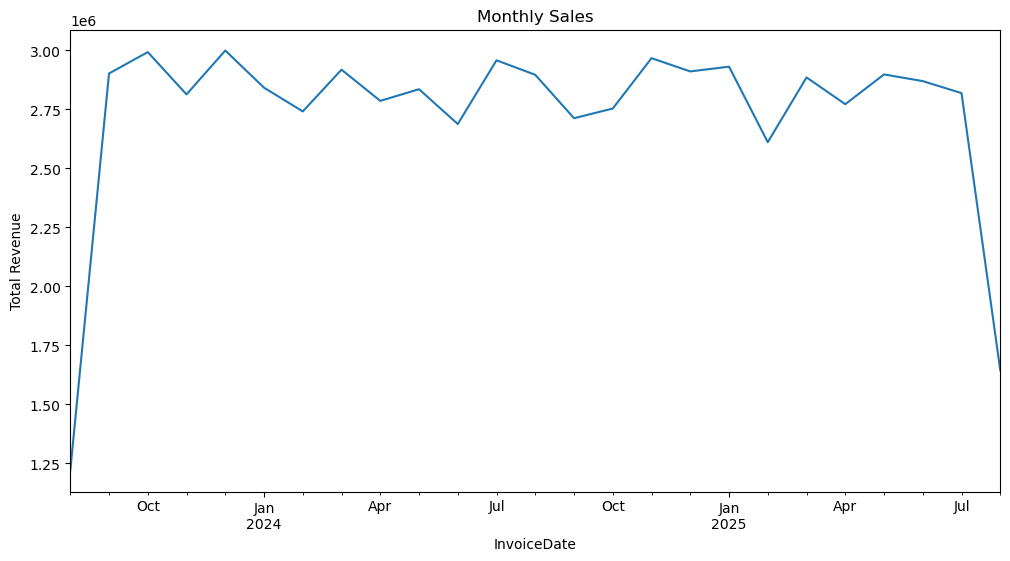

In [107]:
monthly_sales = data.groupby(data['InvoiceDate'].dt.to_period('M'))['TotalAmount'].sum()
monthly_sales.plot(kind='line', figsize=(12,6), title='Monthly Sales')
plt.ylabel('Total Revenue')
plt.show()

# Quartely sales

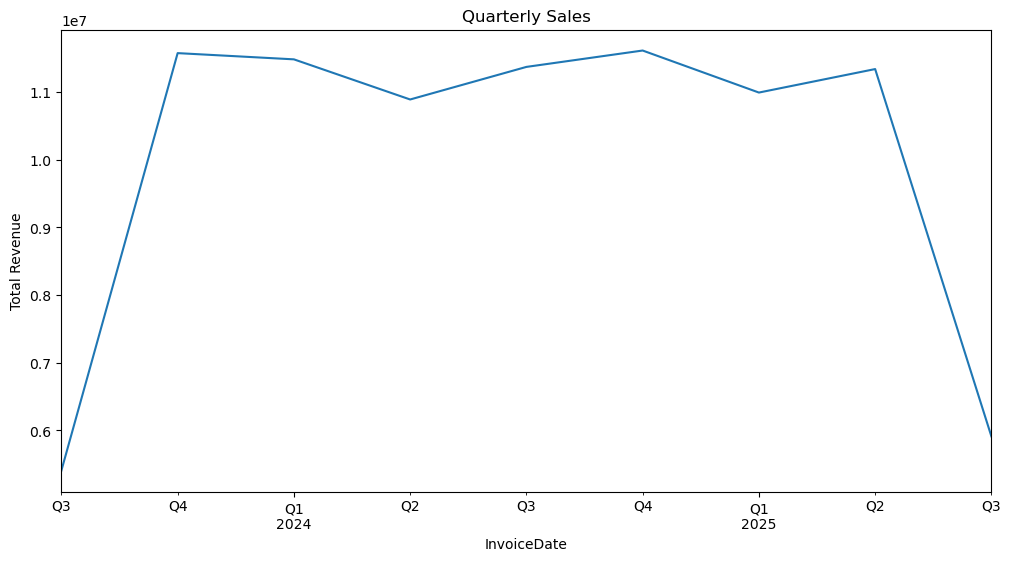

In [108]:
quarterly_sales = sales.groupby(sales['InvoiceDate'].dt.to_period('Q'))['TotalAmount'].sum()
quarterly_sales.plot(kind='line', figsize=(12,6), title='Quarterly Sales')
plt.ylabel('Total Revenue')
plt.show()

# yaerly sales

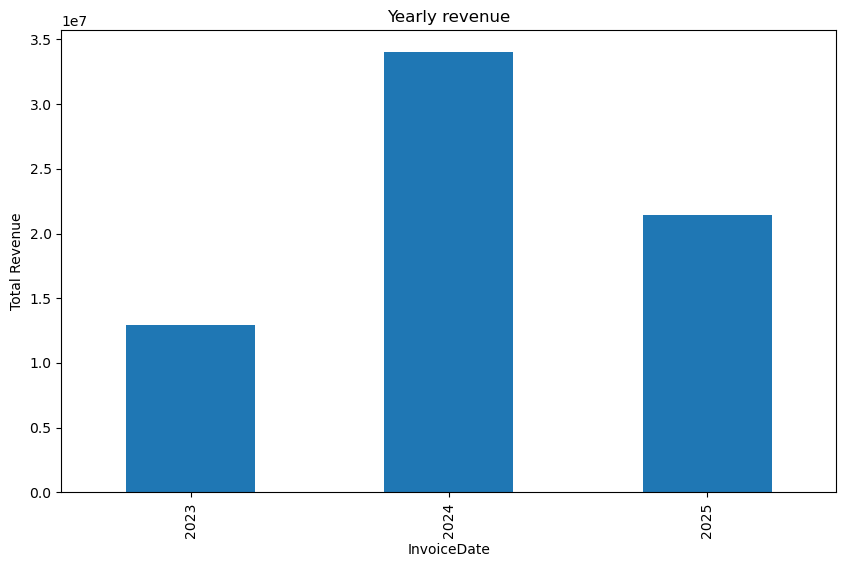

In [109]:
yearly_sales = data.groupby(data['InvoiceDate'].dt.year)['Revenue'].sum()
yearly_sales.plot(kind='bar', figsize=(10,6), title='Yearly revenue')
plt.ylabel('Total Revenue')
plt.show()


# Last year sales by Month

C:\Users\moham\AppData\Local\Temp\ipykernel_18596\3493803598.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Month', y='TotalAmount', data=sales_month, palette='Purples')


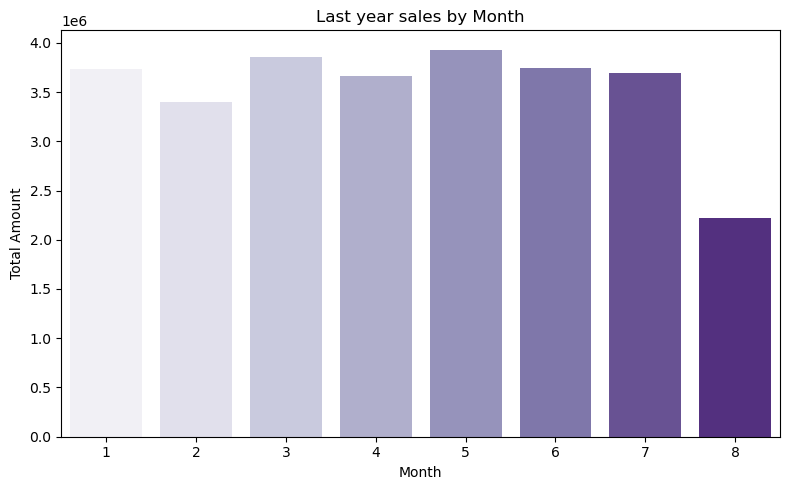

In [110]:
sales['Year'] = sales['InvoiceDate'].dt.year
sales['Month'] = sales['InvoiceDate'].dt.month

last_year = sales['Year'].max()
sales_month = sales[sales['Year'] == last_year].groupby('Month')['TotalAmount'].sum().reset_index()

plt.figure(figsize=(8,5), dpi=100 ,tight_layout=True)
sns.barplot(x='Month', y='TotalAmount', data=sales_month, palette='Purples')
plt.title('Last year sales by Month')
plt.xlabel('Month')
plt.ylabel('Total Amount')
plt.show()

# Revenue by region

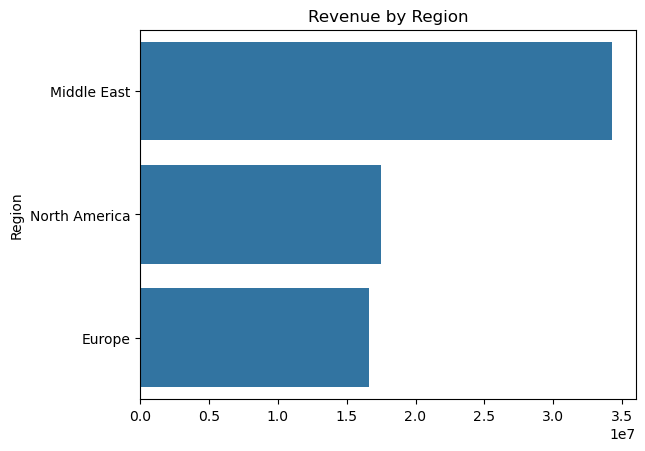

In [133]:
top_regions = data.groupby('Region')['Revenue'].sum().sort_values(ascending=False)
sns.barplot(x=top_regions.values, y=top_regions.index)
plt.title('Revenue by Region')
plt.show()

# Distribution of Purchase Frequency per Customer

Top 10 customers Name
David Smith        606
Anna Smith         602
Sophia Johnson     587
Emma Miller        560
Mohamed Salem      545
Mohamed Tarek      539
Mostafa Ali        534
Mostafa Khaled     531
Michael Miller     522
Sophia Williams    518
Name: InvoiceNo, dtype: int64


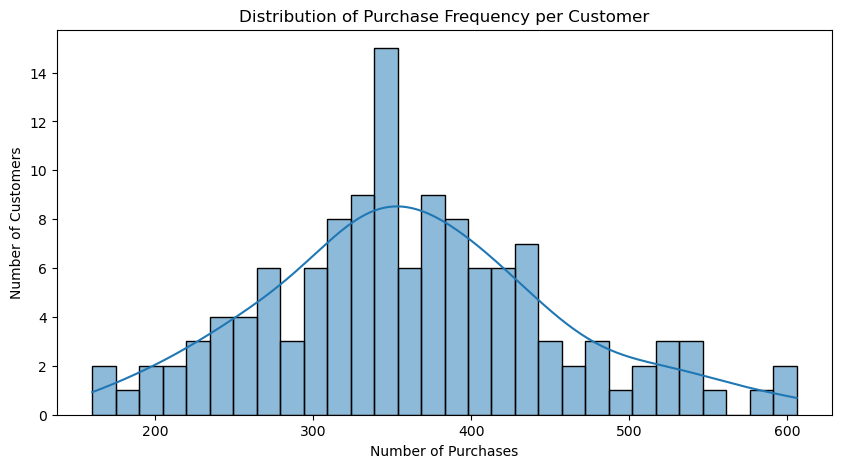

In [113]:
purchase_freq = data.groupby('Name')['InvoiceNo'].nunique().sort_values(ascending=False)
print(f"Top 10 customers {purchase_freq.head(10)}")

plt.figure(figsize=(10,5))
sns.histplot(purchase_freq, bins=30, kde=True)
plt.title("Distribution of Purchase Frequency per Customer")
plt.xlabel("Number of Purchases")
plt.ylabel("Number of Customers")
plt.show()

# Sales by Age


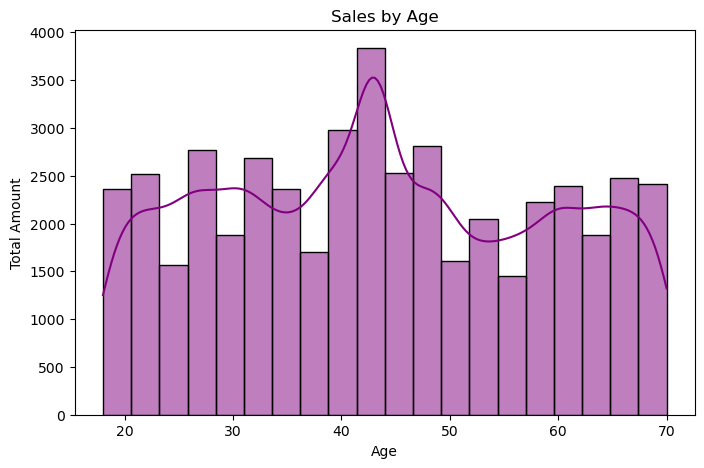

In [136]:
plt.figure(figsize=(8,5))
sns.histplot(data['Age'], bins=20, kde=True, color='purple')
plt.title('Sales by Age')
plt.xlabel('Age')
plt.ylabel('Total Amount')
plt.show()

# Top 10 Products by Revenue

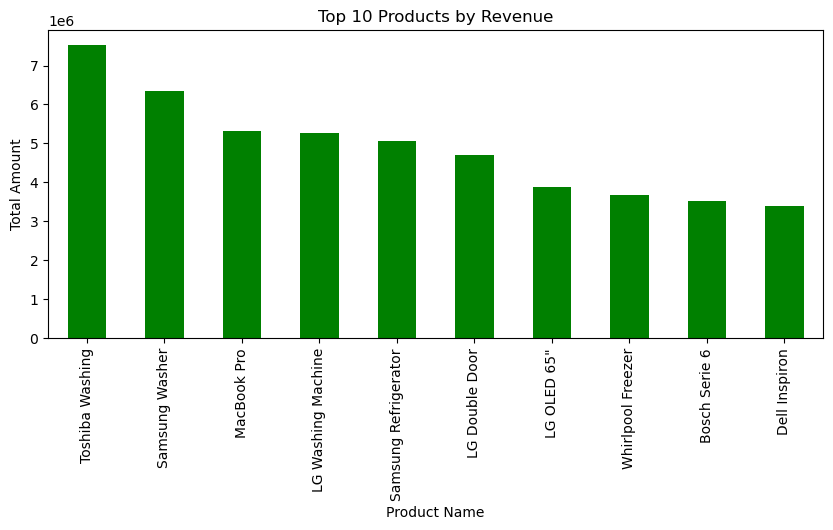

In [134]:
top_products = data.groupby('ProductName')['Revenue'].sum().sort_values(ascending=False).head(10)
top_products.plot(kind='bar', figsize=(10,4), color='green')
plt.title('Top 10 Products by Revenue')
plt.xlabel('Product Name')
plt.ylabel('Total Amount')
plt.show()

# RFM Analysis

In [116]:
now = sales['InvoiceDate'].max() + pd.Timedelta(days=1)
print(f"Reference Date: {now}")

rfm = sales.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (now - x.max()).days,  
    'InvoiceNo': 'nunique',  
    'TotalAmount': 'sum'     
})

cols = ["Recency", "Frequency", "Monetary"]
rfm.columns = cols

rfm['R'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])      
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])  
rfm['M'] = pd.qcut(rfm['Monetary'].rank(method='first'), 5, labels=[1,2,3,4,5])   
 
rfm

Reference Date: 2025-08-18 00:00:00


,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
C0001,55,19,36712.88,1,1,2
C0002,18,32,51275.27,3,5,4
C0003,40,17,30716.81,2,1,1
C0004,32,27,57565.44,2,4,5
C0005,17,29,45177.30,3,4,3
...,...,...,...,...,...,...
C1996,16,27,35275.69,3,4,2
C1997,39,24,66567.72,2,3,5
C1998,2,24,65118.76,5,3,5


In [117]:
rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

def rfm_segment(row):
    R, F, M = int(row['R']), int(row['F']), int(row['M'])
    
    # Champions: 
    if R >= 4 and F >= 4 and M >= 4:
        return 'Champions'
    
    # Loyal Customers: 
    elif R >= 3 and F >= 3 and M >= 3:
        return 'Loyal Customers'
    
    # Potential Loyalists:
    elif R >= 4 and F <= 2 and M >= 3:
        return 'Potential Loyalists'
    
    # New Customers: 
    elif R >= 4 and F <= 2:
        return 'New Customers'
    
    # Promising: 
    elif R >= 3 and F >= 2 and M >= 2:
        return 'Promising'
    
    # Need Attention: 
    elif R <= 2 and F >= 3 and M >= 3:
        return 'Need Attention'
    
    # About to Sleep: 
    elif R <= 3 and F >= 2 and M >= 2:
        return 'About to Sleep'
    
    # At Risk:
    elif R <= 2 and M >= 4:
        return 'At Risk'
    
    # Cannot Lose Them:
    elif R <= 1 and F >= 4 and M >= 4:
        return 'Cannot Lose Them'
    
    # Hibernating: 
    elif R <= 2 and F <= 2:
        return 'Hibernating'
    
    # Lost: 
    elif R <= 1 and F <= 2 and M <= 2:
        return 'Lost'
    
    else:
        return 'Others'

rfm['Customer_Segment'] = rfm.apply(rfm_segment, axis=1)
rfm

,Recency,Frequency,Monetary,R,F,M,RFM_Score,Customer_Segment
CustomerID,,,,,,,,
C0001,55,19,36712.88,1,1,2,112,Hibernating
C0002,18,32,51275.27,3,5,4,354,Loyal Customers
C0003,40,17,30716.81,2,1,1,211,Hibernating
C0004,32,27,57565.44,2,4,5,245,Need Attention
C0005,17,29,45177.30,3,4,3,343,Loyal Customers
...,...,...,...,...,...,...,...,...
C1996,16,27,35275.69,3,4,2,342,Promising
C1997,39,24,66567.72,2,3,5,235,Need Attention
C1998,2,24,65118.76,5,3,5,535,Loyal Customers


C:\Users\moham\AppData\Local\Temp\ipykernel_18596\2375431088.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_segments.values, y=top_segments.index, palette='Purples_d')


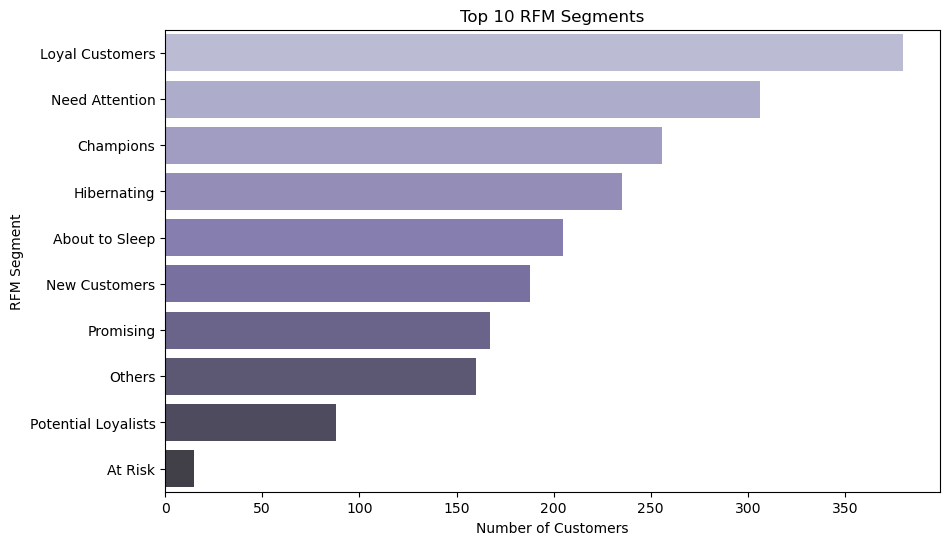

In [141]:
# RFM Segment Top 10
top_segments = rfm['Customer_Segment'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_segments.values, y=top_segments.index, palette='Purples_d')
plt.title('Top 10 RFM Segments')
plt.xlabel('Number of Customers')
plt.ylabel('RFM Segment')
plt.show()

# **Churn prediction**


📊 Random Forest Results:
Accuracy : 0.9169981722395442
Precision: 0.0812807881773399
Recall   : 0.0763888888888889
F1 Score : 0.07875894988066826
ROC-AUC  : 0.7562543587109493

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      8869
           1       0.08      0.08      0.08       432

    accuracy                           0.92      9301
   macro avg       0.52      0.52      0.52      9301
weighted avg       0.91      0.92      0.92      9301



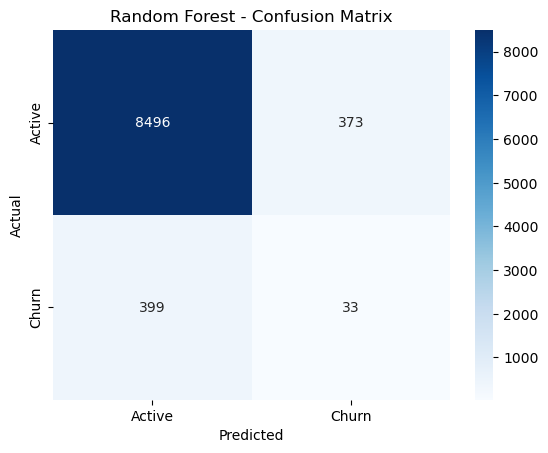

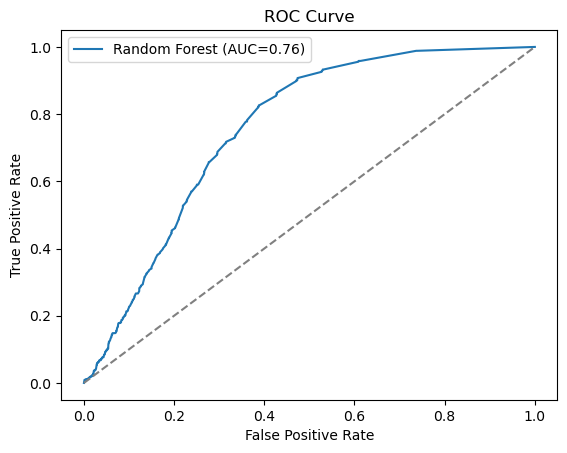

In [119]:
data_features_3= data_features.copy()
data_features_3["InvoiceDate"] = pd.to_datetime(data_features_3["InvoiceDate"], errors="coerce")

last_date = data_features_3["InvoiceDate"].max()
churn_threshold = 90

customer_last_purchase = data_features_3.groupby("CustomerID")["InvoiceDate"].max().reset_index()
customer_last_purchase["days_since_last"] = (last_date - customer_last_purchase["InvoiceDate"]).dt.days
customer_last_purchase["Churn"] = (customer_last_purchase["days_since_last"] > churn_threshold).astype(int)

data_features_3 = data_features_3.merge(customer_last_purchase[["CustomerID","Churn"]], on="CustomerID", how="left")

drop_cols = ["InvoiceDate","CustomerID"]
X = data_features_3.drop(columns=drop_cols + ["Churn"])
y = data_features_3["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# to improve imbalance 
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)


rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
rf.fit(X_res, y_res)
y_pred_rf = rf.predict(X_test)
y_pred_prob_rf = rf.predict_proba(X_test)[:,1]

def evaluate_model(y_true, y_pred, y_prob, model_name):
    print(f"\n📊 {model_name} Results:")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1 Score :", f1_score(y_true, y_pred))
    print("ROC-AUC  :", roc_auc_score(y_true, y_prob))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Active","Churn"], yticklabels=["Active","Churn"])
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC={roc_auc_score(y_true, y_prob):.2f})")
    plt.plot([0,1],[0,1],'--', color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

evaluate_model(y_test, y_pred_rf, y_pred_prob_rf, "Random Forest")

In [120]:
threshold = rfm['Recency'].median()
rfm['Churn'] = (rfm['Recency'] > threshold).astype(int)

rfm['Churn'].value_counts(normalize=True)
rfm

,Recency,Frequency,Monetary,R,F,M,RFM_Score,Customer_Segment,Churn
CustomerID,,,,,,,,,
C0001,55,19,36712.88,1,1,2,112,Hibernating,1
C0002,18,32,51275.27,3,5,4,354,Loyal Customers,0
C0003,40,17,30716.81,2,1,1,211,Hibernating,1
C0004,32,27,57565.44,2,4,5,245,Need Attention,1
C0005,17,29,45177.30,3,4,3,343,Loyal Customers,0
...,...,...,...,...,...,...,...,...,...
C1996,16,27,35275.69,3,4,2,342,Promising,0
C1997,39,24,66567.72,2,3,5,235,Need Attention,1
C1998,2,24,65118.76,5,3,5,535,Loyal Customers,0


# **Clustering (K-Means)** 

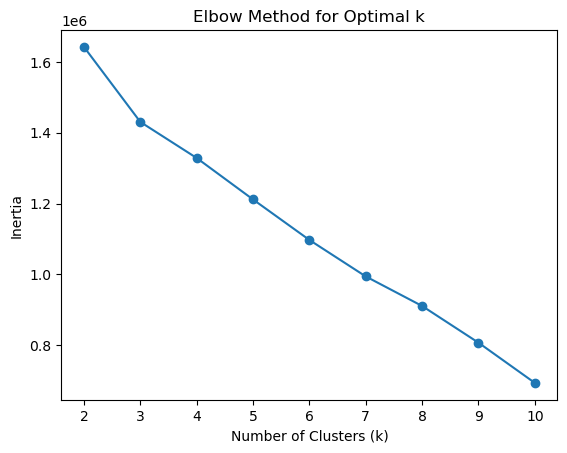

In [121]:
inertia = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

In [122]:
X = rfm[['Recency','Frequency','Monetary']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X_scaled)

rfm['Cluster'] = labels

silhouette = silhouette_score(X_scaled, labels)
print("Silhouette Score:", silhouette)


Silhouette Score: 0.31939402344013523


In [123]:
customer_df = data.groupby("CustomerID").agg({
    "TotalAmount": "sum",   # Total spending
    "Quantity": "sum",      # Total quantity bought
    "InvoiceNo": "nunique", # Frequency (# of invoices)
    "Age": "mean"           # Average age
}).reset_index()

customer_df.rename(columns={
    "TotalAmount": "Total Sales",
    "Quantity": "TotalQuantity",
    "InvoiceNo": "Frequency",
    "Age": "AvgAge"
}, inplace=True)
scaler = StandardScaler()
customer_scaled = pd.DataFrame(scaler.fit_transform(customer_df.drop(columns=["CustomerID"])),
                               columns=customer_df.drop(columns=["CustomerID"]).columns)
print(customer_df.head())
# Compute means
kmeans_customers = KMeans(n_clusters=2, random_state=42)
customer_df["Cluster"] = kmeans_customers.fit_predict(customer_scaled)

customer_df["Cluster"].value_counts()
profile = customer_df.groupby("Cluster")[["Total Sales", "TotalQuantity", "Frequency", "AvgAge"]].mean()

# Sort clusters by Total Sales
cluster_order = profile["Total Sales"].sort_values().index.tolist()

# Map IDs → business-friendly names
cluster_map = {
    cluster_order[0]: "Low-Value Customers",
    cluster_order[1]: "Loyal Big Spenders"
}

customer_df["Segment"] = customer_df["Cluster"].map(cluster_map)

# Drop old numeric cluster column if you want only names
customer_df.drop(columns=["Cluster"])

# Show counts
print(customer_df["Segment"].value_counts())
customer_summary = customer_df.groupby("Segment").agg({
    "Total Sales": "mean",
    "TotalQuantity": "mean",
    "Frequency": "mean",
    "AvgAge": "mean",
    "CustomerID": "count"
}).rename(columns={"CustomerID": "Number of Customers"}).round(2)

customer_summary

customer_profile = customer_df.groupby("Cluster")[["Total Sales", "TotalQuantity", "Frequency", "AvgAge"]].mean()

cluster_order = customer_profile["Total Sales"].sort_values().index.tolist()

cluster_map = {
    cluster_order[0]: "Low-Value Customers",
    cluster_order[1]: "Loyal Big Spenders"
}

customer_df["Segment"] = customer_df["Cluster"].map(cluster_map)

customer_df.drop(columns=["Cluster"], inplace=True)

customer_df[["CustomerID", "Total Sales", "Frequency", "TotalQuantity", "AvgAge", "Segment"]].head(20)


  CustomerID  Total Sales  TotalQuantity  Frequency  AvgAge
0      C0001     20883.75             51         17    67.0
1      C0002     41948.35             87         30    53.0
2      C0003     21105.48             52         15    44.0
3      C0004     45740.66             71         25    29.0
4      C0005     45177.30             90         29    34.0
Segment
Low-Value Customers    1098
Loyal Big Spenders      902
Name: count, dtype: int64


,CustomerID,Total Sales,Frequency,TotalQuantity,AvgAge,Segment
0,C0001,20883.75,17,51,67.0,Low-Value Customers
1,C0002,41948.35,30,87,53.0,Loyal Big Spenders
2,C0003,21105.48,15,52,44.0,Low-Value Customers
3,C0004,45740.66,25,71,29.0,Loyal Big Spenders
4,C0005,45177.30,29,90,34.0,Loyal Big Spenders
5,C0006,22749.77,18,65,25.0,Low-Value Customers
6,C0007,41691.06,19,54,61.0,Low-Value Customers
7,C0008,3690.19,11,31,65.0,Low-Value Customers
8,C0009,25642.86,19,62,37.0,Low-Value Customers
9,C0010,46775.15,24,64,58.0,Loyal Big Spenders


In [124]:
# Step 1: Aggregate product-level data
product_df = data.groupby("ProductID").agg({
    "TotalAmount": "sum",   # total sales
    "Revenue":"sum",        # total revenue
    "Profit":"sum",         # total profit
    "Quantity": "sum",      # total quantity sold
    "Price": "mean",        # avg price
    "Cost": "mean"          # avg cost
}).reset_index()

# Rename column for consistency
product_df.rename(columns={"TotalAmount": "Total Sales"}, inplace=True)

# Step 2: Scale product features
scaler = StandardScaler()
product_scaled = scaler.fit_transform(product_df.drop(columns=["ProductID"]))
# Step 3: Apply KMeans (2 clusters)
kmeans_products = KMeans(n_clusters=2, random_state=42)
product_df["Cluster"] = kmeans_products.fit_predict(product_scaled)
# Step 4: Compute cluster means
product_profile = product_df.groupby("Cluster")[["Total Sales", "Quantity", "Price", "Cost", "Revenue","Profit"]].mean()

# Step 5: Sort clusters by Price (to separate mass-market vs premium)
cluster_order = product_profile["Price"].sort_values().index.tolist()

# Step 6: Map cluster IDs to names
product_map = {
    cluster_order[0]: "Mass-Market Products",
    cluster_order[1]: "Premium Products"
}

# Step 7: Replace cluster numbers with names
product_df["Cluster"] = product_df["Cluster"].map(product_map)

# Step 8: Show results
print(product_df["Cluster"].value_counts())

# Summary table for products
product_summary = product_df.groupby("Cluster").agg({
    "Total Sales": "mean",
    "Quantity": "mean",
    "Price": "mean",
    "Profit":"mean",
    "Cost": "mean",
    "Revenue": "mean",
    "ProductID": "count"
}).rename(columns={"ProductID": "Number of Products"})

product_summary = product_summary.round(2)


# Compute cluster means for products
product_profile = product_df.groupby("Cluster")[["Total Sales", "Quantity", "Price", "Cost", "Revenue","Profit"]].mean()

# Sort clusters by Price
cluster_order = product_profile["Price"].sort_values().index.tolist()

# Map cluster IDs to business-friendly names
product_map = {
    cluster_order[0]: "Mass-Market Products",
    cluster_order[1]: "Premium Products"
}

# Replace Cluster numbers with segment names
product_df["Segment"] = product_df["Cluster"].map(product_map)

# Drop old numeric Cluster column if you want only names
product_df.drop(columns=["Cluster"], inplace=True)

sil_customer = silhouette_score(customer_scaled, kmeans_customers.labels_)
sil_product = silhouette_score(product_scaled, kmeans_products.labels_)

print("Customer Clustering Silhouette Score:", sil_customer)
print("Product Clustering Silhouette Score:", sil_product)


Cluster
Mass-Market Products    45
Premium Products        33
Name: count, dtype: int64
Customer Clustering Silhouette Score: 0.33152677348986537
Product Clustering Silhouette Score: 0.5742449496704315


c:\Users\moham\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [125]:
product_df.head()

,ProductID,Total Sales,Revenue,Profit,Quantity,Price,Cost,Segment
0,P001,1432625.88,1432625.88,116444.85,1869,766.52,571.47,Premium Products
1,P003,120248.34,120248.34,8235.95,1878,64.03,51.06,Mass-Market Products
2,P004,878255.26,878255.26,41645.76,1681,522.46,449.14,Mass-Market Products
3,P005,19075.68,19075.68,992.97,2038,9.36,7.83,Mass-Market Products
4,P006,1958563.54,1958563.54,134422.95,1751,1118.54,891.09,Premium Products


In [126]:
product_summary

,Total Sales,Quantity,Price,Profit,Cost,Revenue,Number of Products
Cluster,,,,,,,
Mass-Market Products,312356.34,1854.22,168.47,29443.60,121.10,312356.34,45
Premium Products,1646060.25,1610.64,1107.06,188213.22,758.13,1646060.25,33


In [127]:
product_df[["ProductID", "Total Sales", "Quantity", "Price", "Revenue", "Segment"]].head(20)


,ProductID,Total Sales,Quantity,Price,Revenue,Segment
0,P001,1432625.88,1869,766.52,1432625.88,Premium Products
1,P003,120248.34,1878,64.03,120248.34,Mass-Market Products
2,P004,878255.26,1681,522.46,878255.26,Mass-Market Products
3,P005,19075.68,2038,9.36,19075.68,Mass-Market Products
4,P006,1958563.54,1751,1118.54,1958563.54,Premium Products
5,P007,2229774.40,1904,1171.10,2229774.40,Premium Products
6,P008,759133.98,1881,403.58,759133.98,Mass-Market Products
7,P009,1262414.93,1907,661.99,1262414.93,Premium Products
8,P010,886350.08,1904,465.52,886350.08,Mass-Market Products
9,P011,85638.80,1720,49.79,85638.80,Mass-Market Products


# **Monthly trend predictions using regression (time series)**

Random Forest Regression Evaluation:
MSE: 284274832977.87354
MAE: 273049.0579800004
R² : -0.23358443376729676


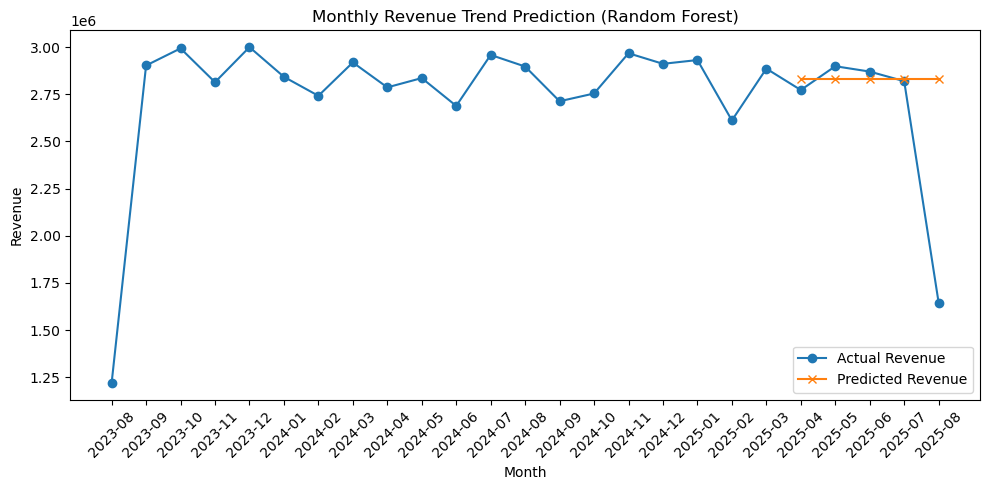

In [128]:
data_features['InvoiceDate'] = pd.to_datetime(data_features['InvoiceDate'], errors='coerce')

monthly_data = data_features.groupby(data_features['InvoiceDate'].dt.to_period('M')).agg({"Revenue": "sum"}).reset_index()
monthly_data['Month'] = monthly_data['InvoiceDate'].astype(str)

monthly_data['Month_Num'] = np.arange(len(monthly_data))


X = monthly_data[['Month_Num']]
y = monthly_data['Revenue']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

rf = RandomForestRegressor(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Random Forest Regression Evaluation:")
print("MSE:", mse)
print("MAE:", mae)
print("R² :", r2)

plt.figure(figsize=(10,5))
plt.plot(monthly_data['Month'], monthly_data['Revenue'], label='Actual Revenue', marker='o')
plt.plot(monthly_data['Month'].iloc[-len(y_test):], y_pred, label='Predicted Revenue', marker='x')
plt.xticks(rotation=45)
plt.title("Monthly Revenue Trend Prediction (Random Forest)")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.legend()
plt.tight_layout()
plt.show()

RMSE: 37119.476765060244
R² Score: 0.9222918136855448


C:\Users\moham\AppData\Local\Temp\ipykernel_18596\2331054983.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_importance.values, y=feat_importance.index, palette="viridis")


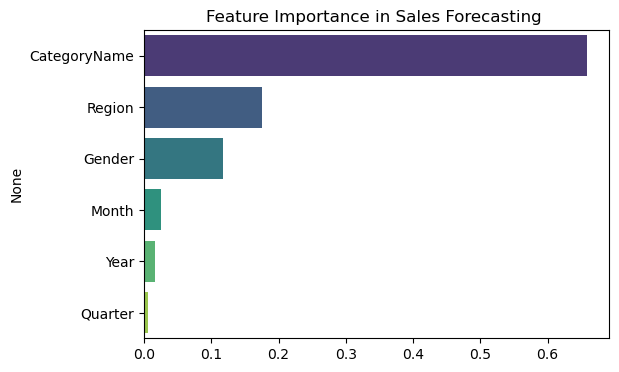

In [129]:
# Ensure InvoiceDate is datetime
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])

# 2. Extract time features
data["Year"] = data["InvoiceDate"].dt.year
data["Month"] = data["InvoiceDate"].dt.month
data["Quarter"] = data["InvoiceDate"].dt.quarter

# 3. Aggregate monthly sales by category, gender, region
monthly_sales = data.groupby(
    ["Year", "Month", "Quarter", "CategoryName", "Gender", "Region"]
)["TotalAmount"].sum().reset_index()


le_cat = LabelEncoder()
monthly_sales["CategoryName"] = le_cat.fit_transform(monthly_sales["CategoryName"])

le_gender = LabelEncoder()
monthly_sales["Gender"] = le_gender.fit_transform(monthly_sales["Gender"])

le_region = LabelEncoder()
monthly_sales["Region"] = le_region.fit_transform(monthly_sales["Region"])

# 5. Define features & target
X = monthly_sales[["Year", "Month", "Quarter", "CategoryName", "Gender", "Region"]]
y = monthly_sales["TotalAmount"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R² Score:", r2)


feat_importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(x=feat_importance.values, y=feat_importance.index, palette="viridis")
plt.title("Feature Importance in Sales Forecasting ")
plt.show()


In [ ]:
future_data = pd.DataFrame({
    "Year": [2025, 2025],
    "Month": [1, 2],
    "Quarter": [1, 1],
    "CategoryName": [le_cat.transform(["Electronics"])[0], le_cat.transform(["Clothing"])[0]],
    "Gender": [le_gender.transform(["Male"])[0], le_gender.transform(["Female"])[0]],
    "Region": [le_region.transform(["Europe"])[0], le_region.transform(["Middle East"])[0]]
})

future_predictions = rf_model.predict(future_data)
future_data["Predicted Sales"] = future_predictions
future_data["CategoryName_Original"] = le_cat.inverse_transform(future_data["CategoryName"])
future_data["Gender_Original"] = le_gender.inverse_transform(future_data["Gender"])
future_data["Region_Original"] = le_region.inverse_transform(future_data["Region"])

print(future_data[["Year", "Month", "CategoryName_Original", "Gender_Original", "Region_Original", "Predicted Sales"]])

   Year  Month CategoryName_Original Gender_Original Region_Original  \
0  2025      1           Electronics            Male          Europe   
1  2025      2              Clothing          Female     Middle East   

   Predicted Sales  
0      103884.1769  
1       13166.9979  
